# Reproducing "Deep Bayesian Active Learning with Image Data"

Imports

In [ ]:
# PyTorch
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader

# Other
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import sys

Constants

In [ ]:
T = 20
NUM_CLASSES = 10
EPOCHS = 50
INIT_TRAIN_SIZE = 20
VALID_SIZE = 100
BATCH_SIZE = 128
POOL_BATCH_SIZE = 128
SUBPOOL_SIZE = 10_000
EPSILON = sys.float_info.min
ACQ_SIZE = 10
ACQ_STEPS = 100
REPS = 3
CPU = "cpu"
CUDA = "cuda"
DEVICE = torch.device(CUDA if torch.cuda.is_available() else CPU)
WDS = [
    0.5e-2, 1e-2,
    0.5e-3, 1e-3,
    0.5e-4, 1e-4,
    0.5e-5, 1e-5,
    0.5e-6, 1e-6
]
NUM_WORKERS = 2
def init_cm(overrides):
  # default
  COST_MATRIX = torch.ones(NUM_CLASSES,NUM_CLASSES).to(DEVICE) * 10
  COST_MATRIX.fill_diagonal_(0.0)

  # overrides
  for (i, j, val) in overrides:
    COST_MATRIX[i,j] = val
    COST_MATRIX[j,i] = val

  return COST_MATRIX

cm_overrides = [
    (2, 3, 1.0),
    (3, 5, 1.0),
    (3, 9, 1.0),
    (5, 6, 1.0),
    (5, 9, 1.0),
    (0, 8, 1.0),
    (6, 8, 1.0),
    (6, 9, 1.0),
    (8, 9, 1.0),
]
COST_MATRIX = init_cm(cm_overrides)


Load MNIST Dataset

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, p=1.0):
        self.std = std
        self.mean = mean
        self.p = p

    def __call__(self, tensor):
        if torch.rand(()) < self.p:
            tensor = (tensor + torch.randn(tensor.size()) * self.std + self.mean).clamp(0.0, 1.0)
        return tensor

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)),
     AddGaussianNoise(std=100.0, p=0.3)])
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

print(f'\ntrain data size: {len(dataset)}')
print(f'test data size: {len(test_dataset)}')

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.57MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


train data size: 60000
test data size: 10000


Neural Net

In [ ]:
class BCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd = nn.Sequential(
            # shape 1,28,28
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4),
            nn.ReLU(),
            # shape 32,25,25
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4),
            nn.ReLU(),
            # shape 32,22,22
            nn.MaxPool2d(2, 2),
            # shape 32,11,11
            nn.Dropout(p=0.25),
            nn.Flatten(),
            nn.Linear(32*11*11, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, NUM_CLASSES),
            # Criterion expects raw logits, so no softmax
        )

    def forward(self, x):
        return self.fwd(x)

In [ ]:
def mc_dropout(model):
  for module in model.modules():
      if isinstance(module, nn.Dropout):
        module.train()

In [ ]:
def test_model(model, test_loader, mc):
  correct = 0
  total = 0
  T_eff = 1

  # put model in eval mode
  model.eval()
  if mc:
    mc_dropout(model)
    T_eff = T

  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for images, labels in test_loader:
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          # multiple forward passes
          t_outputs = []
          for _ in range(T_eff):
            outputs = model(images)
            outputs = F.softmax(outputs, dim=1)
            # unsqueeze to add extra dimension
            t_outputs.append(outputs.unsqueeze(0))
          # concat t's
          t_outputs = torch.cat(t_outputs, dim=0)


          # average across t's
          mean_output = torch.mean(t_outputs, dim=0)

          _, predicted = torch.max(mean_output, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  return accuracy

In [ ]:
def train_model(train_loader, valid_loader, wd, mc):
  model = BCNN().to(DEVICE)

  # not specified in paper so use example reference
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), weight_decay=wd)

  for epoch in range(EPOCHS):
    model.train()
    for i, data in enumerate(train_loader, 0):
          inputs, labels = data
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

  return model

Active Learning

In [ ]:
def pool_predictions(model, pool_loader, mc):
  T_eff = 1

  # put model in eval mode
  model.eval()
  if mc:
    mc_dropout(model)
    T_eff = T

  with torch.no_grad():
      for images, labels in pool_loader:
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          # multiple forward passes
          t_outputs = []
          for _ in range(T_eff):
            outputs = model(images)
            outputs = F.softmax(outputs, dim=1)
            # unsqueeze to add extra dimension
            t_outputs.append(outputs.unsqueeze(0))
          # concat t's
          t_outputs = torch.cat(t_outputs, dim=0)

          yield t_outputs

def max_entropy(model, pool_loader, mc):
  scores = []
  # t_ouputs: (T, batch_size, c)
  for t_outputs in pool_predictions(model, pool_loader, mc=mc):
    # (batch_size, c)
    mean_pct = torch.mean(t_outputs, dim=0)
    mulogmu = mean_pct * torch.log(mean_pct + EPSILON)
    # (batch_size)
    batch_scores = - torch.sum(mulogmu, dim=1)

    scores.append(batch_scores)

  scores = torch.cat(scores)
  top_scores, top_indices = torch.topk(scores, ACQ_SIZE)

  return top_scores, top_indices

def bald(model, pool_loader, mc):
  scores = []
  # t_ouputs: (T, batch_size, c)
  for t_outputs in pool_predictions(model, pool_loader, mc=mc):
    # (batch_size, c)
    mean_pct = torch.mean(t_outputs, dim=0)
    mulogmu = mean_pct * torch.log(mean_pct + EPSILON)
    # (batch_size)
    first_term = torch.sum(mulogmu, dim=1)

    # (T, batch_size, c)
    plogp = t_outputs * torch.log(t_outputs + EPSILON)
    # (T, batch_size)
    sum_c = torch.sum(plogp, dim=2)
    # (batch_size)
    second_term = torch.mean(sum_c, dim=0)

    batch_scores = - first_term + second_term
    scores.append(batch_scores)

  scores = torch.cat(scores)
  top_scores, top_indices = torch.topk(scores, ACQ_SIZE)

  return top_scores, top_indices

def vr(model, pool_loader, mc):
  scores = []
  # t_ouputs: (T, batch_size, c)
  for t_outputs in pool_predictions(model, pool_loader, mc=mc):
    # (T, batch_size)
    predictions = torch.argmax(t_outputs, dim=2)
    # (batch_size)
    modes, _ = torch.mode(predictions, dim=0)
    # (T, batch_size) <== (T, batch_size) == (1, batch_size)
    mask = (predictions == torch.unsqueeze(modes, dim=0))
    # (batch_size)
    counts = torch.sum(mask, dim=0)
    batch_scores = 1.0 - (counts/t_outputs.size(dim=0))

    scores.append(batch_scores)

  scores = torch.cat(scores)
  top_scores, top_indices = torch.topk(scores, ACQ_SIZE)

  return top_scores, top_indices

def mean_std(model, pool_loader, mc):
  scores = []
  # t_ouputs: (T, batch_size, c)
  for t_outputs in pool_predictions(model, pool_loader, mc=mc):
    squared = t_outputs ** 2
    # (batch_size, c)
    mean_pct = torch.mean(t_outputs, dim=0)
    mean_pct_sq = torch.mean(squared, dim=0)
    var = mean_pct_sq - mean_pct**2
    # Ensure no values < 0
    var = torch.clamp(var, min=0)
    std = torch.sqrt(var)

    batch_scores = torch.mean(std, dim=1)
    scores.append(batch_scores)

  scores = torch.cat(scores)
  top_scores, top_indices = torch.topk(scores, ACQ_SIZE)

  return top_scores, top_indices

def cost_bald(model, pool_loader, mc):
  scores = []
  # t_ouputs: (T, batch_size, c)
  for t_outputs in pool_predictions(model, pool_loader, mc=mc):
    # STANDARD BALD

    # (batch_size, c)
    mean_pct = torch.mean(t_outputs, dim=0)
    mulogmu = mean_pct * torch.log(mean_pct + EPSILON)
    # (batch_size)
    first_term = torch.sum(mulogmu, dim=1)

    # (T, batch_size, c)
    plogp = t_outputs * torch.log(t_outputs + EPSILON)
    # (T, batch_size)
    sum_c = torch.sum(plogp, dim=2)
    # (batch_size)
    second_term = torch.mean(sum_c, dim=0)

    bald_scores = - first_term + second_term

    # RISK SCORES
    #(batch_size)
    predictions = torch.argmax(mean_pct, dim=1)
    #(batch_size,c)
    sample_costs = COST_MATRIX[predictions]
    # (batch_size)
    risk_scores = torch.sum(mean_pct * sample_costs, dim=1)

    batch_scores = bald_scores * risk_scores
    scores.append(batch_scores)

  scores = torch.cat(scores)
  top_scores, top_indices = torch.topk(scores, ACQ_SIZE)

  return top_scores, top_indices

def baseline(model, pool_loader, mc):
  pool_size = len(pool_loader.dataset)
  top_scores = torch.zeros(pool_size)
  top_indices = torch.randperm(pool_size)[:ACQ_SIZE]

  return top_scores, top_indices

Experiments  

In [ ]:
def exp1(a_func, mc):
  results = []

  # set up initial random but balanced training set
  gen = torch.Generator().manual_seed(42)
  N = len(dataset)
  pool_size = N - VALID_SIZE

  train_indices = []
  targets = dataset.targets
  for c in range(NUM_CLASSES):
    indices = (targets == c).nonzero(as_tuple=True)[0]
    shuffled = indices[torch.randperm(len(indices), generator=gen)]
    train_indices.extend(shuffled.tolist()[:(INIT_TRAIN_SIZE//10)])

  remaining_indices = list(set(range(N)) - set(train_indices))
  remaining_indices = torch.tensor(remaining_indices)[
      torch.randperm(len(remaining_indices), generator=gen)
  ]

  valid_indices = remaining_indices[:VALID_SIZE].tolist()
  pool_indices = remaining_indices[VALID_SIZE:].tolist()

  train_subset = Subset(dataset, train_indices)
  valid_subset = Subset(dataset, valid_indices)

  train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
  valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  # hyperparameter optimisation using grid search
  wdc = None
  best_acc = -1
  bcnn = None
  for candidate in WDS:
    curr_bcnn = train_model(train_loader, valid_loader, wd=candidate, mc=mc)
    valid_accuracy = test_model(curr_bcnn, valid_loader, mc=mc)

    if valid_accuracy > best_acc:
      best_acc = valid_accuracy
      wdc = candidate
      bcnn = curr_bcnn

  print(f"Trained Initial Model, Validation Accruacy={best_acc}, WD={wdc}")

  # test initial model
  test_accuracy = test_model(bcnn, test_loader, mc=mc)
  print(f'Initial Test Accuracy: {test_accuracy}%')
  results.append(test_accuracy)

  # active learning
  pbar = tqdm.trange(ACQ_STEPS)
  pbar.set_description("Active Learning")
  pbar_postfix = {}

  for i in pbar:
    pbar_postfix["Status"] = "Running Acq Func"
    pbar.set_postfix(pbar_postfix)

    # use random data points from pool set
    pool_size = len(pool_indices)
    subpool_size = min(pool_size, SUBPOOL_SIZE)
    rand_subpool_idxs = torch.randperm(pool_size)[:subpool_size]
    subpool_idxs = torch.tensor(pool_indices)[rand_subpool_idxs].tolist()
    subpool_subset = Subset(dataset, subpool_idxs)
    subpool_loader = DataLoader(subpool_subset, batch_size=POOL_BATCH_SIZE, shuffle=False, pin_memory=True)

    # score using acquisition function
    top_scores, top_indices = a_func(bcnn, subpool_loader, mc=mc)

    # update pool and training data
    acq_tensor = torch.tensor(subpool_idxs)[top_indices.to(CPU)]
    acq_list = acq_tensor.tolist()
    train_indices.extend(acq_list)
    pool_indices = list(set(pool_indices) - set(acq_list))

    train_subset = Subset(dataset, train_indices)
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)

    # train model
    pbar_postfix["Status"] = "Training Model"
    pbar.set_postfix(pbar_postfix)

    wdn = wdc * INIT_TRAIN_SIZE / len(train_indices)
    bcnn = train_model(train_loader, valid_loader, wd=wdn, mc=mc)

    # test model
    pbar_postfix["Status"] = "Testing Model"
    pbar.set_postfix(pbar_postfix)

    test_accuracy = test_model(bcnn, test_loader, mc=mc)
    results.append(test_accuracy)

    pbar_postfix["Acq Step"] = f"{i+1}"
    pbar_postfix["Test Acc"] = f"{test_accuracy}%"
    pbar.set_postfix(pbar_postfix)

  return results

Main

In [ ]:
# run experiment
trials = []
for _ in range(REPS):
  results = exp1(cost_bald, mc=True)
  trials.append(results)

print("\n")
print(trials)

Trained Initial Model, Validation Accruacy=44.0, WD=1e-05
Initial Test Accuracy: 39.9%


Active Learning: 100%|██████████| 100/100 [23:21<00:00, 14.02s/it, Status=Testing Model, Acq Step=100, Test Acc=71.86%]


Trained Initial Model, Validation Accruacy=44.0, WD=1e-05
Initial Test Accuracy: 40.34%


Active Learning: 100%|██████████| 100/100 [23:13<00:00, 13.94s/it, Status=Testing Model, Acq Step=100, Test Acc=71.42%]


Trained Initial Model, Validation Accruacy=43.0, WD=5e-07
Initial Test Accuracy: 41.01%


Active Learning: 100%|██████████| 100/100 [22:54<00:00, 13.74s/it, Status=Testing Model, Acq Step=100, Test Acc=71.23%]



[[39.9, 41.17, 46.37, 48.73, 53.62, 55.71, 57.6, 58.84, 61.58, 59.63, 62.23, 59.94, 66.71, 66.29, 66.68, 67.25, 66.22, 66.93, 66.73, 67.59, 67.53, 68.03, 68.65, 66.84, 66.44, 67.99, 68.5, 69.54, 69.06, 69.15, 69.5, 69.73, 70.27, 69.46, 70.24, 69.76, 70.03, 69.23, 69.96, 70.35, 70.37, 70.06, 70.52, 70.68, 71.15, 70.62, 69.81, 69.66, 70.1, 70.5, 70.02, 70.67, 69.99, 70.45, 70.91, 71.04, 70.61, 71.56, 70.76, 70.76, 71.28, 71.08, 71.39, 70.69, 70.94, 70.92, 71.45, 70.73, 70.71, 71.53, 71.66, 71.56, 71.0, 71.47, 72.1, 70.9, 71.06, 71.28, 70.6, 71.17, 70.58, 72.01, 71.54, 71.14, 72.15, 71.85, 71.45, 72.47, 70.95, 71.33, 72.2, 72.48, 70.96, 71.18, 71.25, 71.85, 70.96, 72.25, 71.49, 72.24, 71.86], [40.34, 49.71, 48.26, 54.71, 52.94, 54.33, 54.26, 57.61, 57.23, 56.24, 59.76, 53.14, 60.64, 62.97, 65.07, 64.94, 66.82, 65.51, 66.22, 64.97, 65.19, 66.84, 67.23, 66.22, 65.44, 67.09, 66.7, 68.6, 69.06, 69.54, 68.45, 69.31, 69.55, 70.14, 69.35, 69.02, 69.55, 70.47, 70.06, 69.51, 68.74, 69.6, 71.25, 

Plot

In [ ]:
# data: list of {"data": [], "label": str, "color": str}
def plot_graph(data, std=False):
  x = [i*ACQ_SIZE for i in range(ACQ_STEPS+1)]

  for line in data:
    y = np.mean(line["data"], axis=0)
    plt.plot(x,y, label=line["label"], color=line["color"])
    if std:
      y_std = np.std(line["data"], axis=0)
      plt.fill_between(x, y - y_std, y + y_std, color=line["color"], alpha=0.2)

  plt.ylim(40, 100.0)

  plt.xticks(np.arange(0, 1100, 100))
  plt.yticks(np.arange(80.0, 102.0, 2.0))

  plt.legend(loc='lower right')
  plt.grid(linestyle='--')
  plt.show()

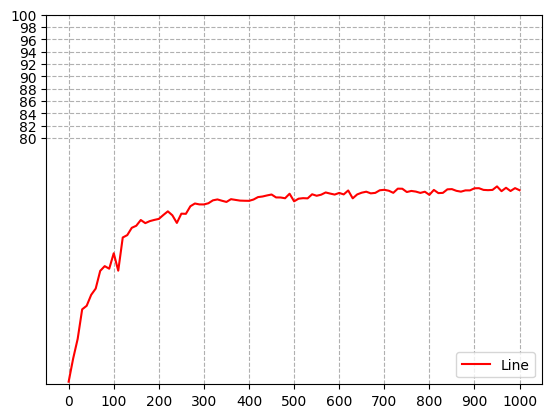

In [ ]:
plot_data = [
    {"data": trials, "label": "Line", "color": "red"},
]

plot_graph(plot_data, std=False)